# Analytic functions

Analytic functions allow us to perform complex calculations with relatively straightforward syntax. For instance, we can quickly calculate moving averages and running totals, among other quantities.

## Syntax

To understand how to write analytic functions, we'll work with a small table containing data from two different people who are training for a race. The id column identifies each runner, the date column holds the day of the training session, and time shows the time (in minutes) that the runner dedicated to training. Say we'd like to calculate a moving average of the training times for each runner, where we always take the average of the current and previous training sessions. We can do this with the following query:

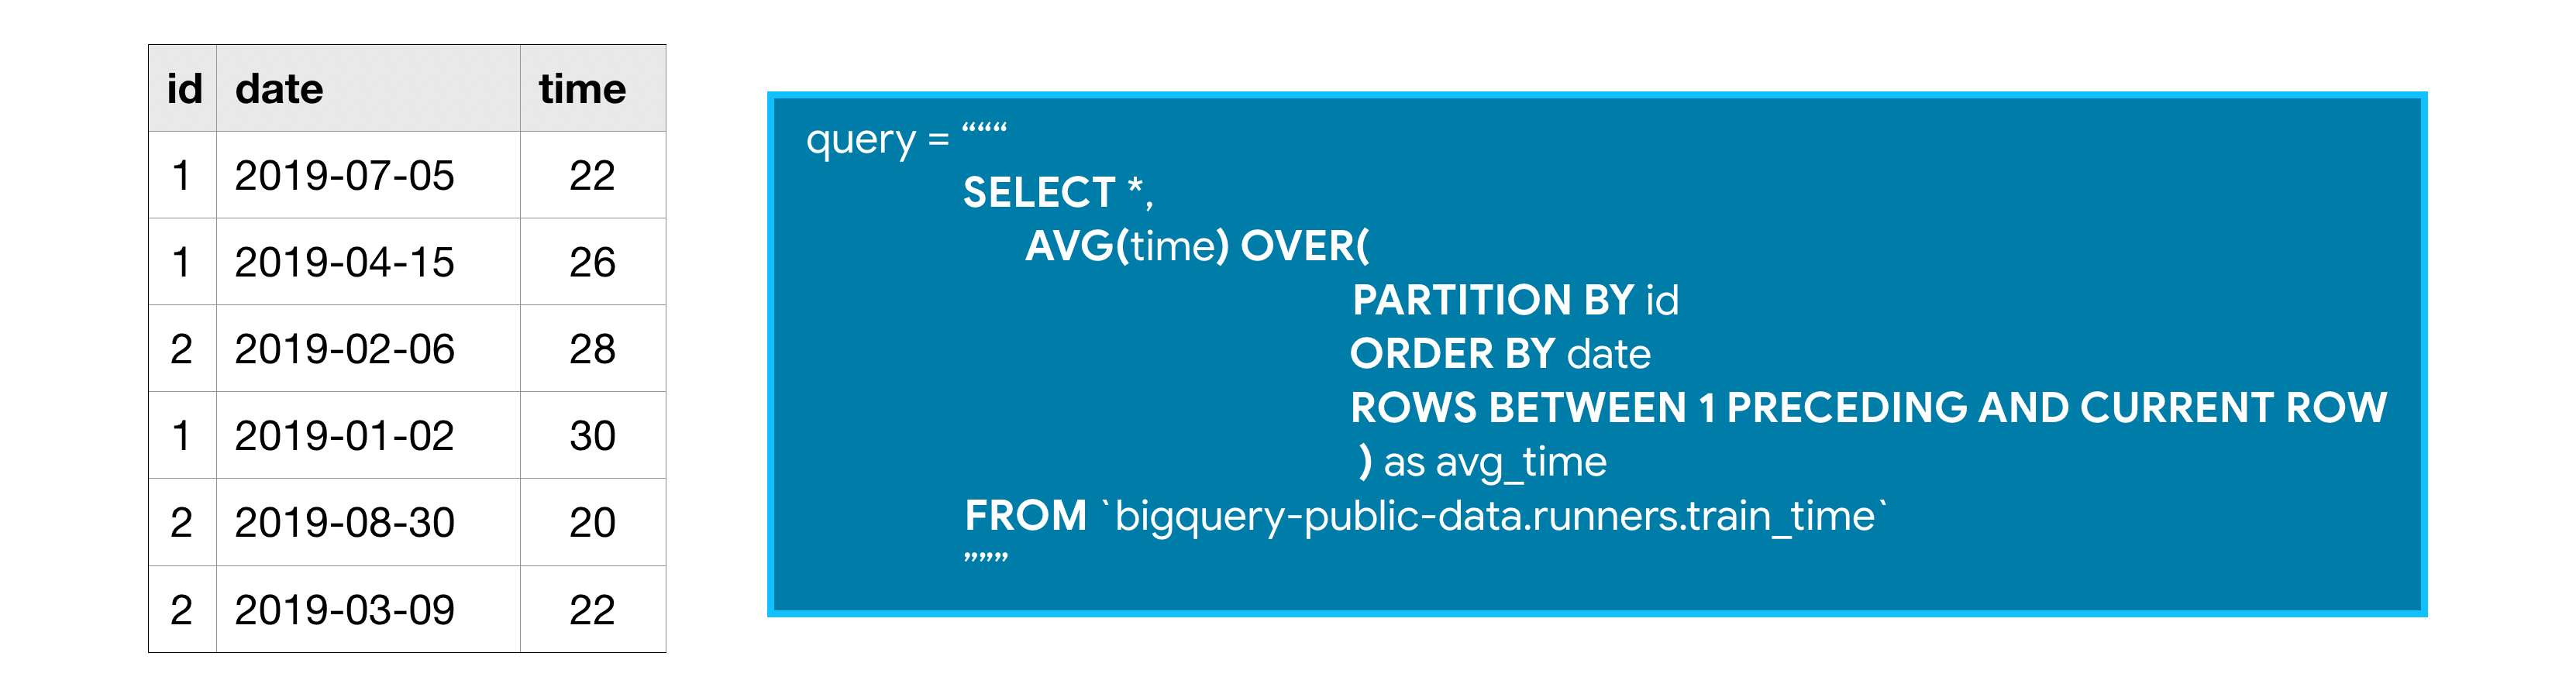

All analytic functions have an OVER clause, which defines the sets of rows used in each calculation. The OVER clause has three (optional) parts:

- The PARTITION BY clause divides the rows of the table into different groups. In the query above, we divide by id so that the calculations are separated by runner.
- The ORDER BY clause defines an ordering within each partition. In the sample query, ordering by the date column ensures that earlier training sessions appear first.
- The final clause (ROWS BETWEEN 1 PRECEDING AND CURRENT ROW) is known as a window frame clause. It identifies the set of rows used in each calculation. We can refer to this group of rows as a window. (Actually, analytic functions are sometimes referred to as analytic window functions or simply window functions!)

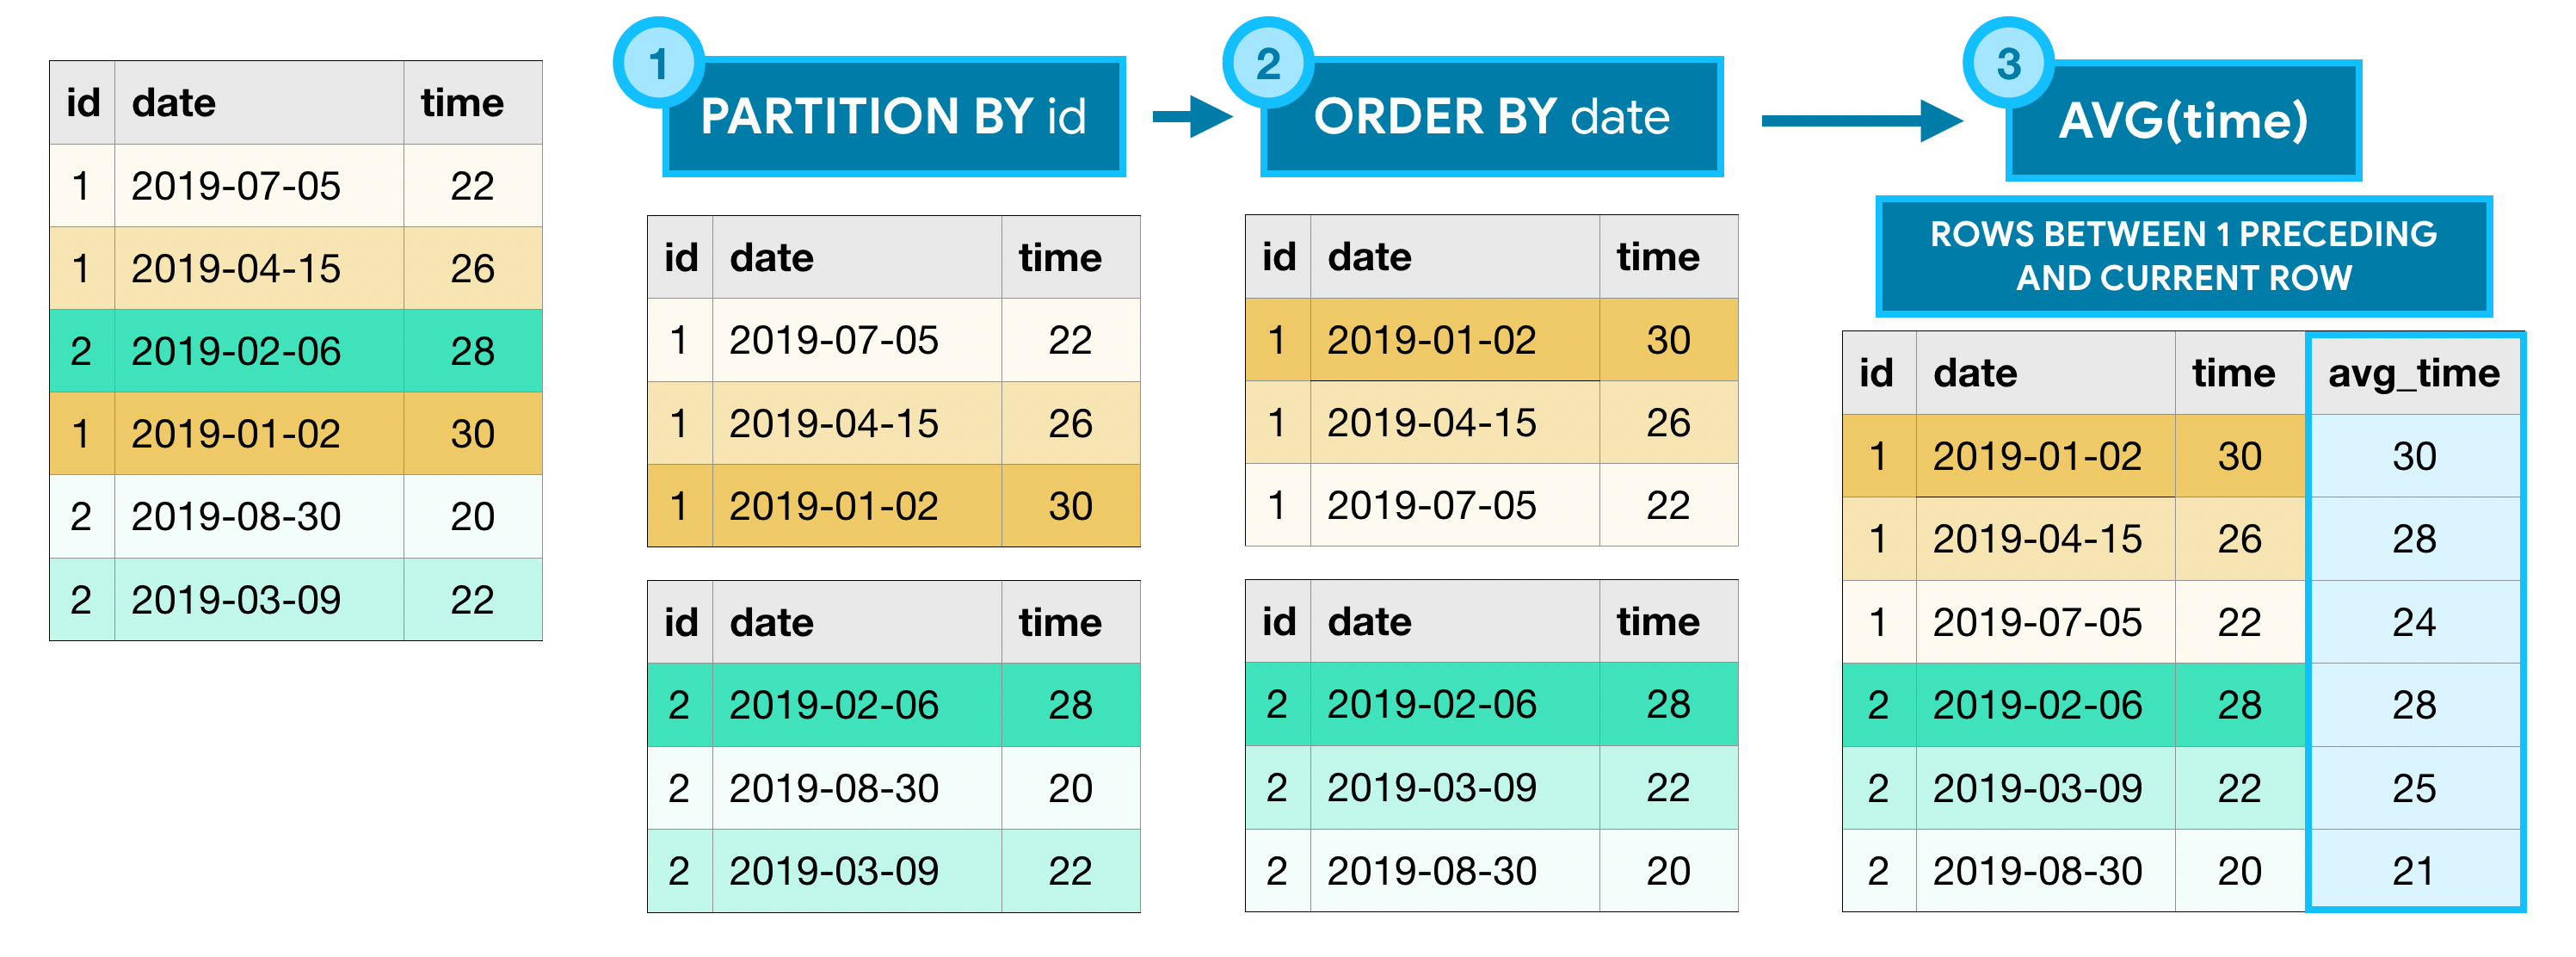

## Three types of analytic functions

The example above uses only one of many analytic functions. BigQuery supports a wide variety of analytic functions, and we'll explore a few here. For a complete listing, you can take a look at the documentation.

1) Analytic aggregate functions: \
    As you might recall, AVG() (from the example above) is an aggregate function. The OVER clause is what ensures that it's treated as an analytic (aggregate) function. Aggregate functions take all of the values within the window as input and return a single value.

    - MIN() (or MAX()) - Returns the minimum (or maximum) of input values
    - AVG() (or SUM()) - Returns the average (or sum) of input values
    - COUNT() - Returns the number of rows in the input
2) Analytic navigation functions: \
    Navigation functions assign a value based on the value in a (usually) different row than the current row.

    - FIRST_VALUE() (or LAST_VALUE()) - Returns the first (or last) value in the input
    - LEAD() (and LAG()) - Returns the value on a subsequent (or preceding) row
3) Analytic numbering functions: \
    Numbering functions assign integer values to each row based on the ordering.

    - ROW_NUMBER() - Returns the order in which rows appear in the input (starting with 1)
    - RANK() - All rows with the same value in the ordering column receive the same rank value, where the next row receives a rank value which increments by the number of rows with the previous rank value.

## Exercises
Here, we'll use window functions to answer questions about the [Chicago Taxi Trips](https://www.kaggle.com/chicago/chicago-taxi-trips-bq) dataset.


In [4]:
from google.cloud import bigquery

client = bigquery.Client(project="sqlbigquery7711")

dataset_ref = client.dataset("chicago_taxi_trips", project="bigquery-public-data")

dataset = client.get_dataset(dataset_ref)

table_ref = dataset_ref.table("taxi_trips")

table = client.get_table(table_ref)

client.list_rows(table, max_results=5).to_dataframe()

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,...,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location
0,5003bdd51918a9b5a52134096663b4d7e02395c5,2130bc5fd239a4e3b304662424fb4cc7db0ca7abf78cc5...,2013-02-25 14:15:00+00:00,2013-02-25 14:15:00+00:00,120,0.00,<NA>,<NA>,<NA>,<NA>,...,NaN,NaN,Cash,None,NaN,NaN,None,NaN,NaN,None
1,720534d264001b2644f682755b294067fdf1da21,4bb55b69e710d1792f5fd4888001f4ff0ce34040f976f8...,2013-06-02 08:15:00+00:00,2013-06-02 08:15:00+00:00,60,0.02,<NA>,<NA>,<NA>,<NA>,...,NaN,NaN,Cash,None,NaN,NaN,None,NaN,NaN,None
2,515b9a6d5234a4d1fb559dca27b3e1cc541a342d,4bb55b69e710d1792f5fd4888001f4ff0ce34040f976f8...,2013-06-24 06:15:00+00:00,2013-06-24 06:15:00+00:00,60,0.04,<NA>,<NA>,1,77,...,NaN,NaN,Cash,None,42.009623,-87.670167,POINT (-87.67016685690001 42.0096228806),41.986712,-87.663416,POINT (-87.6634164054 41.9867117999)
3,8afd48d966bf464e93127f43b72a8e405596a8eb,0150188f8c8e8973a198d4af0b427fca8ff48df2662d6b...,2013-02-01 07:00:00+00:00,2013-02-02 00:00:00+00:00,61560,0.00,<NA>,<NA>,<NA>,<NA>,...,0.0,0.0,Cash,None,NaN,NaN,None,NaN,NaN,None
4,fe73a44f01fdd2a3c740a01f53e97ec2ced93455,0150188f8c8e8973a198d4af0b427fca8ff48df2662d6b...,2013-02-01 07:00:00+00:00,2013-02-02 00:00:00+00:00,60900,0.00,<NA>,<NA>,<NA>,<NA>,...,0.0,0.0,Cash,None,NaN,NaN,None,NaN,NaN,None


### 1) How can you predict the demand for taxis?
Say you work for a taxi company, and you're interested in predicting the demand for taxis. Towards this goal, you'd like to create a plot that shows a rolling average of the daily number of taxi trips. Amend the (partial) query below to return a DataFrame with two columns:

- trip_date - contains one entry for each date from January 1, 2016, to March 31, 2016.
- avg_num_trips - shows the average number of daily trips, calculated over a window including the value for the current date, along with the values for the preceding 3 days and the following 3 days, as long as the days fit within the three-month time frame. For instance, when calculating the value in this column for January 3, 2016, the window will include the number of trips for the preceding 2 days, the current date, and the following 3 days.

In [18]:
avg_num_trips_query = """
                      WITH trips_by_day AS
                      (
                      SELECT DATE(trip_start_timestamp) AS trip_date,
                          COUNT(*) as num_trips
                      FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                      WHERE trip_start_timestamp > '2016-01-01' AND trip_start_timestamp < '2016-04-01'
                      GROUP BY trip_date
                      )
                      SELECT trip_date,
                          AVG(num_trips)
                          OVER (
                               ORDER BY num_trips
                               ROWS BETWEEN 3 PRECEDING AND 3 FOLLOWING
                               ) AS avg_num_trips
                      FROM trips_by_day
                      """

query_job = client.query(avg_num_trips_query)

query_df = query_job.to_dataframe()

In [19]:
query_df

,trip_date,avg_num_trips
0,2016-03-25,96133.857143
1,2016-02-11,101769.428571
2,2016-03-28,73552.714286
3,2016-01-26,80465.000000
4,2016-03-01,89036.857143
...,...,...
86,2016-01-05,72005.285714
87,2016-02-14,86362.857143
88,2016-01-23,79663.142857
89,2016-03-30,89643.714286


### 2) Can you separate and order trips by community area?

The query below returns a DataFrame with three columns from the table: `pickup_community_area`, `trip_start_timestamp`, and `trip_end_timestamp`.  

Amend the query to return an additional column called `trip_number` which shows the order in which the trips were taken from their respective community areas.  So, the first trip of the day originating from community area 1 should receive a value of 1; the second trip of the day from the same area should receive a value of 2.  Likewise, the first trip of the day from community area 2 should receive a value of 1, and so on.

Note that there are many numbering functions that can be used to solve this problem (depending on how you want to deal with trips that started at the same time from the same community area); to answer this question, please use the **RANK()** function.

In [7]:
trip_number_query = """
                    SELECT pickup_community_area,
                        trip_start_timestamp,
                        trip_end_timestamp,
                        RANK() 
                        OVER(
                            PARTITION BY pickup_community_area
                            ORDER BY trip_start_timestamp
                        ) AS trip_number
                    FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                    WHERE DATE(trip_start_timestamp) = '2013-10-03'
                    """

query_job = client.query(trip_number_query)

query_df = query_job.to_dataframe()

In [10]:
query_df.head(20)

,pickup_community_area,trip_start_timestamp,trip_end_timestamp,trip_number
0,37,2013-10-03 01:15:00+00:00,2013-10-03 01:15:00+00:00,1
1,37,2013-10-03 10:00:00+00:00,2013-10-03 10:00:00+00:00,2
2,37,2013-10-03 13:00:00+00:00,2013-10-03 13:15:00+00:00,3
3,37,2013-10-03 14:00:00+00:00,2013-10-03 14:15:00+00:00,4
4,37,2013-10-03 15:15:00+00:00,2013-10-03 16:15:00+00:00,5
5,37,2013-10-03 17:15:00+00:00,2013-10-03 17:30:00+00:00,6
6,37,2013-10-03 19:45:00+00:00,2013-10-03 20:00:00+00:00,7
7,37,2013-10-03 21:15:00+00:00,2013-10-03 21:45:00+00:00,8
8,11,2013-10-03 00:00:00+00:00,2013-10-03 00:30:00+00:00,1
9,11,2013-10-03 00:00:00+00:00,2013-10-03 00:00:00+00:00,1


In [11]:
query_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84268 entries, 0 to 84267
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   pickup_community_area  70752 non-null  Int64              
 1   trip_start_timestamp   84268 non-null  datetime64[us, UTC]
 2   trip_end_timestamp     84248 non-null  datetime64[us, UTC]
 3   trip_number            84268 non-null  Int64              
dtypes: Int64(2), datetime64[us, UTC](2)
memory usage: 2.7 MB


In [14]:
query_df.describe(include='all')
query_df.isnull().sum()  

pickup_community_area    13516
trip_start_timestamp         0
trip_end_timestamp          20
trip_number                  0
dtype: int64

### 3) How much time elapses between trips?

The (partial) query in the code cell below shows, for each trip in the selected time frame, the corresponding `taxi_id`, `trip_start_timestamp`, and `trip_end_timestamp`. 

Your task in this exercise is to edit the query to include an additional `prev_break` column that shows the length of the break (in minutes) that the driver had before each trip started (this corresponds to the time between `trip_start_timestamp` of the current trip and `trip_end_timestamp` of the previous trip).  Partition the calculation by `taxi_id`, and order the results within each partition by `trip_start_timestamp`.

Some sample results are shown below, where all rows correspond to the same driver (or `taxi_id`).  Take the time now to make sure that the values in the `prev_break` column make sense to you!

![first_commands](https://storage.googleapis.com/kaggle-media/learn/images/qjvQzg8.png)

Note that the first trip of the day for each driver should have a value of **NaN** (not a number) in the `prev_break` column.

In [17]:
break_time_query = """
                   SELECT taxi_id,
                       trip_start_timestamp,
                       trip_end_timestamp,
                       TIMESTAMP_DIFF(
                           trip_start_timestamp, 
                           LAG(trip_end_timestamp, 1) 
                               OVER (
                                    PARTITION BY taxi_id 
                                    ORDER BY trip_start_timestamp), 
                           MINUTE) as prev_break
                   FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                   WHERE DATE(trip_start_timestamp) = '2013-10-03' 
                   """

query_job = client.query(break_time_query)

query_df = query_job.to_dataframe()

query_df.head()

,taxi_id,trip_start_timestamp,trip_end_timestamp,prev_break
0,03cfe911366a3ec59f30b328348efcbcb5a55aabe3befe...,2013-10-03 17:15:00+00:00,2013-10-03 18:15:00+00:00,240
1,12052a7776cbfcf53d9daa2805ef852de2dbfb28bc38a6...,2013-10-03 08:30:00+00:00,2013-10-03 08:30:00+00:00,-30
2,12052a7776cbfcf53d9daa2805ef852de2dbfb28bc38a6...,2013-10-03 19:30:00+00:00,2013-10-03 19:45:00+00:00,195
3,191fd58fcca9f1d212a7aa0cf83cabb461b02b1f9642e3...,2013-10-03 20:00:00+00:00,2013-10-03 20:00:00+00:00,1155
4,248103cdd73487ab06014ae0c4bb8dea2cca9402efe076...,2013-10-03 10:00:00+00:00,2013-10-03 10:15:00+00:00,540


Query Breakdown
- Columns Selected:

    - taxi_id: Identifies each taxi uniquely.
    - trip_start_timestamp: The start time of the current trip.
    - trip_end_timestamp: The end time of the current trip.
    - prev_break: A calculated column that represents the break time (in minutes) between the end of the previous trip and the start of the current trip.
- Calculating prev_break:

    - The TIMESTAMP_DIFF function calculates the time difference between two timestamps.
    - The two timestamps are:
    - trip_start_timestamp: The start time of the current trip.
    - The second argument is the end time of the previous trip, derived using the LAG function.
- Using LAG:

    - LAG(trip_end_timestamp, 1) OVER (...): The LAG function looks back to the previous row within a partition to get the trip_end_timestamp of the last trip.
    - PARTITION BY taxi_id: This ensures that the LAG function only looks at previous trips for the same taxi_id, i.e., each taxi’s trips are considered separately.
    - ORDER BY trip_start_timestamp: This sorts trips chronologically within each taxi's partition, so the query considers the previous trip in time order.
- Resulting prev_break:

    - TIMESTAMP_DIFF(..., MINUTE): This specifies that the difference should be calculated in minutes.
    - The result, prev_break, is the duration (in minutes) between the end of the last trip and the start of the current trip for each taxi.